In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mlx.core as mx
from mlx.optimizers import SGD
from scipy.interpolate import BSpline


start with a nice and easy, smooth sine curve (with some added noise) as our input data:

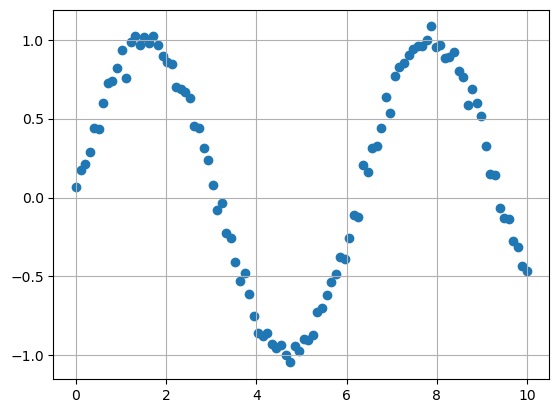

In [2]:
X = np.linspace(0, 10, 100)
Y = np.sin(X) + 0.05 * np.random.randn(100)

plt.scatter(X,Y)
plt.grid()

now define some knots. these are just spaced points between the beginning and end of the expected input data, and they define the region of data that a given spline should be responsible for. note that the knots at the endpoints are repeated - this helps ensure smoothness. there are some situations where you want different spacing (e.g. [chebyshev nodes](https://rohangautam.github.io/blog/chebyshev_gauss/)), but here we use evenly-spaced knots.

In [3]:

k = 2  # spline degree
num_knots = 10
knots = np.linspace(X.min(), X.max(), num_knots - k + 2)
knots = np.concatenate((
    [knots[0]] * k,
    knots,
    [knots[-1]] * k
))

the main 'bit' to get about fitting splines is that we'll transform the input features (`X`) into a coordinate system made up of a basis set of b-spline curves. if we aren't moving the knot positions, then this part doesn't need to be differentiable, so we can use scipy.interpolate's BSpline method to transform teh input features (sklearn's SplineTransformer could work too):  

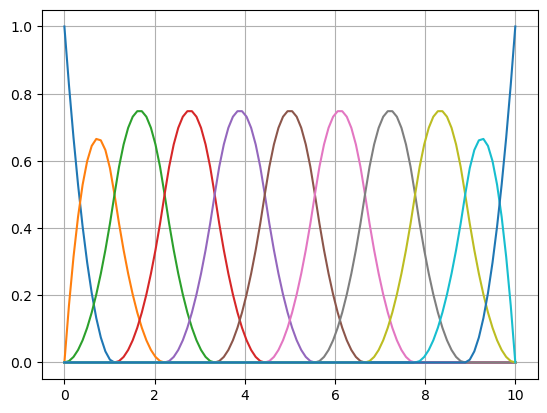

In [4]:
def bspline_basis_matrix(x, knots, degree):
    n_bases = len(knots) - degree - 1
    B = np.zeros((len(x), n_bases))
    for i in range(n_bases):
        coeffs = np.zeros(n_bases)
        coeffs[i] = 1.0
        spline = BSpline(knots, coeffs, degree)
        B[:, i] = spline(x)
    return B

# B for basis.
B = bspline_basis_matrix(X, knots, k)


# what does B look like? Each column of our transformed feature matrix
# is a b-spline, which is a smooth curve that looks kinda gaussian, 
# and they are situated at the knots: 

for i in range(B.shape[1]):
    plt.plot(X, B[:,i])
plt.grid()

so if our features are constant, what gets fitted? The resultant curve will be a sum of each of those b-spline curves, scaled by learned coefficients. Fitting linear combinations is easy - for example let's first try with sklearn's linear regression:

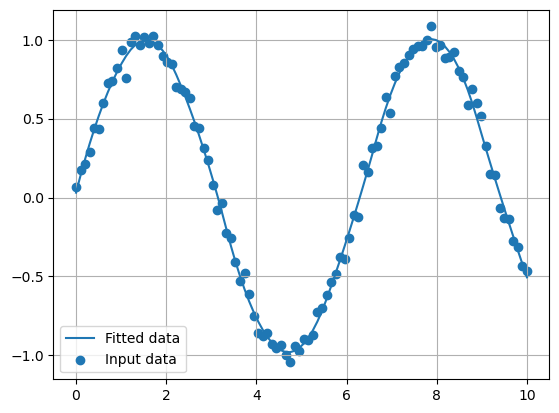

In [5]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False).fit(B, Y)

# et voila - perfect fit. 
plt.plot(
    X, 
    lr.predict(B),
    label='Fitted data'
)
plt.grid()
plt.scatter(X,Y, label='Input data');
plt.legend()

we can also look at how the individual B-spline curves have been modified by the regression procedure. this is my favourite part of b-splines fitting:

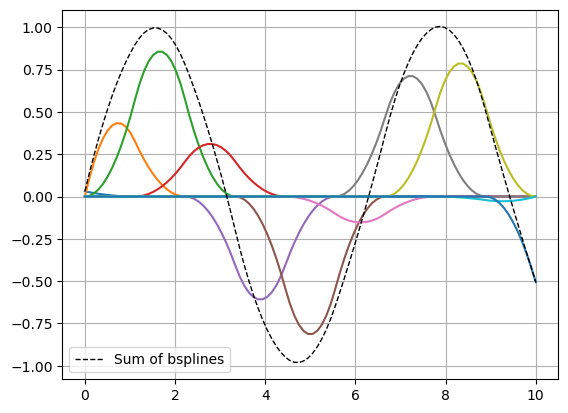

In [6]:
w = lr.coef_

for i in range(w.shape[0]):
    plt.plot(
        X,
        B[:,i] * w[i]
    )


plt.plot(
    X, 
    B @ w, 
    c='k', 
    linestyle='--', 
    label='Sum of bsplines', 
    linewidth=1,
)
plt.grid()
plt.legend()

if you want to include splines in a more complicated model, such as neural networks or whatever other learning procedure, it helps to make this all differentiable. since it's just fitting linear coefficients, that isn't too hard. Here it is with MLX. 

To make things interesting, we can plot the change in the b-spline components across the fitting procedure: 

Step 0: Loss = 0.474911
Step 20: Loss = 0.418942
Step 40: Loss = 0.368519
Step 60: Loss = 0.324308
Step 80: Loss = 0.285536
Step 100: Loss = 0.251527
Step 120: Loss = 0.221690
Step 140: Loss = 0.195508
Step 160: Loss = 0.172527
Step 180: Loss = 0.152351


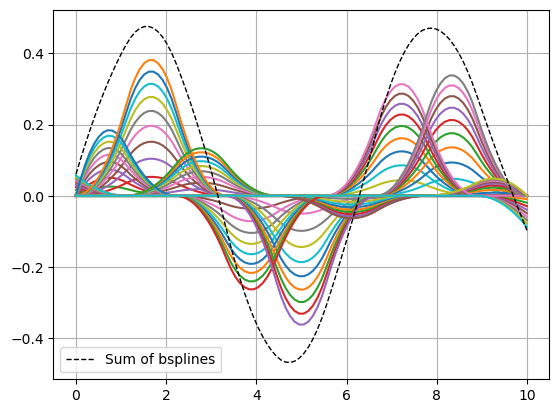

In [7]:

B_mx = mx.array(B)
Y_mx = mx.array(Y).reshape(-1, 1)
w = mx.zeros((B.shape[1], 1))

def loss_fn(w):
    pred = B_mx @ w
    return ((pred - Y_mx) ** 2).mean()

# of course use any other optimizer here if desired. 
optimizer = SGD(learning_rate=1e-2, momentum=0.5, nesterov=True)
optimizer.init_single(w, optimizer.state)

lg_funct = mx.value_and_grad(loss_fn)

for step in range(200):
    loss, grads = lg_funct(w)
    
    if step % 20 == 0:
        print(f"Step {step}: Loss = {loss.item():.6f}")

        Y_pred = (B_mx @ w).squeeze()
        
        for i in range(w.shape[0]):
            plt.plot(
                X,
                B[:,i] * w[i]
                
            )
    w = optimizer.apply_single(grads, w, optimizer.state)
    
    

plt.plot(
    X, 
    B @ w, 
    c='k', 
    linestyle='--', 
    label='Sum of bsplines', 
    linewidth=1,
)
plt.grid()
plt.legend()
    

one last fun thing we can do before moving on is change the 'degree' of the b-splines and visualize what that does to the individual b-splines:


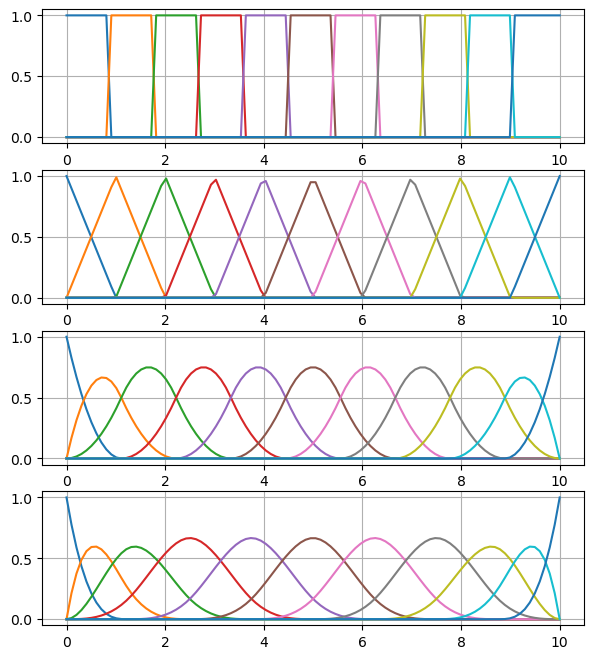

In [8]:
fig, ax = plt.subplots(4,1,figsize=(7,8))
for k in [0,1,2,3]:
    knots = np.linspace(X.min(), X.max(), num_knots - k + 2)
    knots = np.concatenate((
        [knots[0]] * k,
        knots,
        [knots[-1]] * k
    ))
    
    B = bspline_basis_matrix(X, knots, k)
    
    for i in range(B.shape[1]):
        ax[k].plot(X, B[:,i])
    ax[k].grid()

now same thing, but with fitted coefficients:

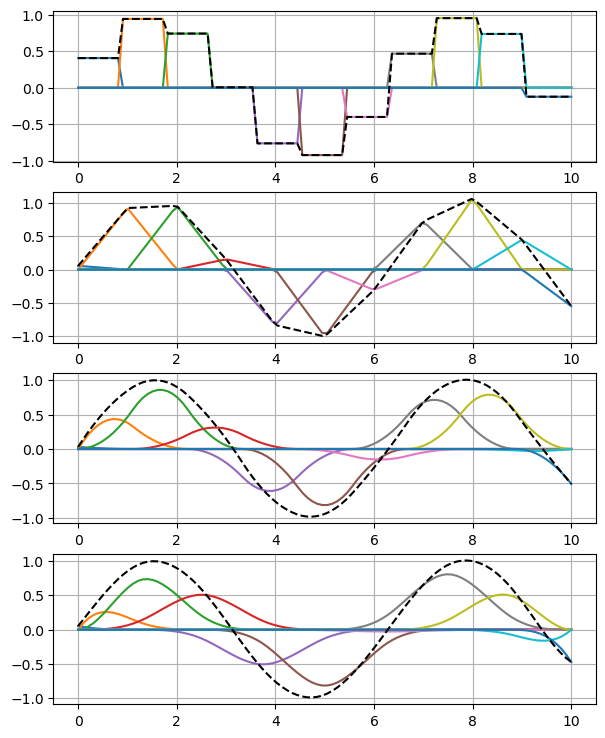

In [9]:
fig, ax = plt.subplots(4,1,figsize=(7,9))
for k in [0,1,2,3]:
    knots = np.linspace(X.min(), X.max(), num_knots - k + 2)
    knots = np.concatenate((
        [knots[0]] * k,
        knots,
        [knots[-1]] * k
    ))
    
    B = bspline_basis_matrix(X, knots, k)
    
        
    lr = LinearRegression(fit_intercept=False).fit(B, Y)
    w = lr.coef_

    for i in range(w.shape[0]):
        ax[k].plot(
            X,
            B[:,i] * w[i]
        )
    ax[k].grid()
    ax[k].plot(X, B@w, c='k', linestyle='--')
    
lr = LinearRegression(fit_intercept=False).fit(B, Y)

# now do it in2D

we can do a similar thing for surfaces, too. it's not really 2D b-splines - it's two sets of 1D B-splines that get broadcast and multiplied against each other.

if we kept the same amount of knots in each dimension, then we'd have `n_knots^2` coefficients to learn - that makes it easy to get wobbly surfaces (overfitting noise). so in this case we'll reduce reduce the number of knots to get a smooth(er) surface.

another thing we can observe in 2D, and i have no idea why, is that SGD finds a smoother fit. One could also try PLSRegressor to enforce smoothness, or use shrinkage (l2 penalty works great here)

In [10]:
N = 1000
np.random.seed(0)
x = np.random.rand(N)
x = np.sort(x)
y = np.random.rand(N)

#noisy manta-ray / saddle looking thing:
z = np.sin(np.pi * x) * np.cos(np.pi * y) + 0.05 * np.random.randn(N)


def makeknots(lo, hi, num_knots, k):
    knots = np.linspace(lo, hi, num_knots - k + 2)
    knots = np.concatenate((
        [knots[0]] * k,
        knots,
        [knots[-1]] * k
    ))
    return knots

num_knots = 6
k = 3
knots_x = makeknots(x.min(), x.max(), num_knots, k)
knots_y = makeknots(y.min(), y.max(), num_knots, k)

Bx = bspline_basis_matrix(x, knots_x, k)
By = bspline_basis_matrix(y, knots_y, k)

B2D = np.einsum("ni,nj->nij", Bx, By)  # (N, n_knot_x, n_knot_y)
B2D_flat = B2D.reshape(N, -1)

In [11]:

def fit_mlx_2d(B2D_flat, z, nsteps=5000):
    B2D_flat = mx.array(B2D_flat)
    ndim = B2D_flat.shape[1]
    z_mx = mx.array(z).reshape(-1, 1)
    w = mx.zeros((ndim, 1))
    def loss_fn(w):
        pred = B2D_flat @ w
        return ((pred - z_mx) ** 2).mean()
    opt = SGD(learning_rate = 0.1)
    for step in range(nsteps):
        loss, grads = mx.value_and_grad(loss_fn)(w)
        w = opt.apply_single(grads, w, opt.state)
        if step % 500 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")
            
    return w

def fit_linreg_2d(B2D_flat, z):
    w = LinearRegression(fit_intercept=False).fit(B2D_flat, z).coef_
    return w

from sklearn.linear_model import SGDRegressor
def fit_sgdreg_2d(B2D_flat, z):
    w = SGDRegressor(fit_intercept=False, penalty=None, max_iter=10_000).fit(B2D_flat, z).coef_
    return w

In [12]:
#inference grid spanning the whole range:

grid_x, grid_y = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
gx = grid_x.ravel()
gy = grid_y.ravel()

Bx_grid = bspline_basis_matrix(gx, knots_x, k)
By_grid = bspline_basis_matrix(gy, knots_y, k)
B2D_grid = np.einsum("ni,nj->nij", Bx_grid, By_grid)
B2D_grid_flat = B2D_grid.reshape(-1, B2D_flat.shape[1])

# try MLX first:

Step 0, Loss: 0.2656
Step 500, Loss: 0.0093
Step 1000, Loss: 0.0033
Step 1500, Loss: 0.0027
Step 2000, Loss: 0.0025
Step 2500, Loss: 0.0024
Step 3000, Loss: 0.0024
Step 3500, Loss: 0.0024
Step 4000, Loss: 0.0023
Step 4500, Loss: 0.0023
MSE: 0.002319095398710208


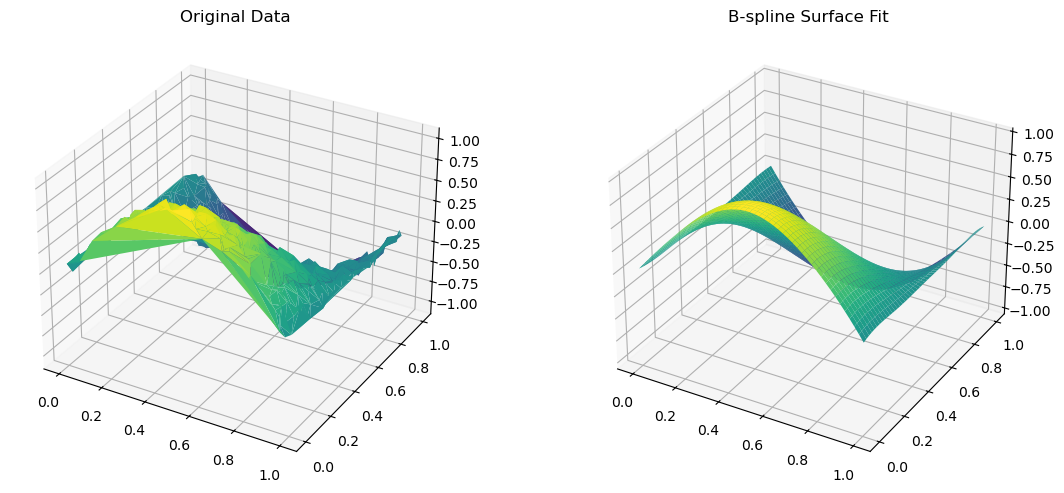

In [13]:
w = fit_mlx_2d(B2D_flat, z)
print("MSE:", (((B2D_flat @ w).flatten()-z)**2).mean())
z_pred = (B2D_grid_flat @ w).reshape(50, 50)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2)
ax1.set_title("Original Data")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(grid_x, grid_y, z_pred, cmap='viridis')
ax2.set_title("B-spline Surface Fit")
plt.tight_layout()
plt.show()

# Linear regression

MSE: 0.0022639701160549652


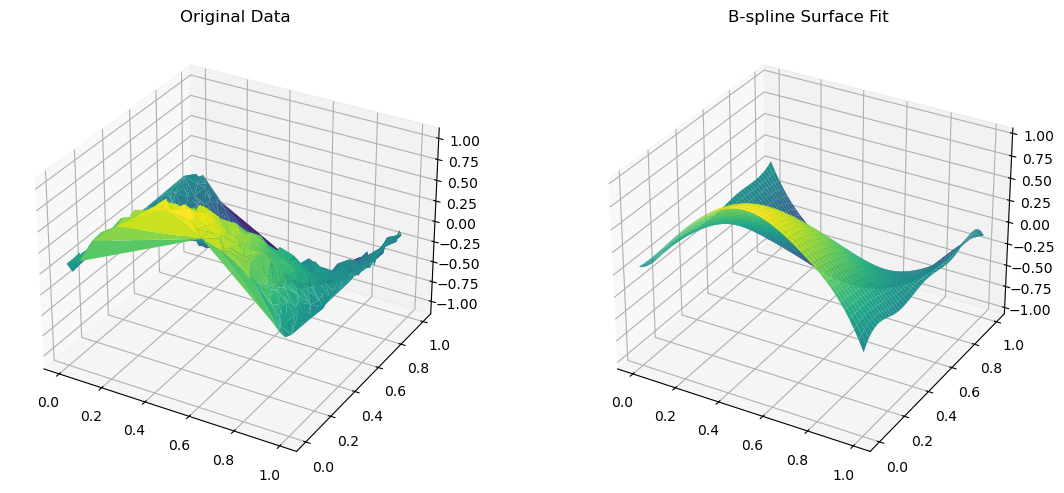

In [14]:
w = fit_linreg_2d(B2D_flat, z)
print("MSE:", (((B2D_flat @ w).flatten()-z)**2).mean())
z_pred = (B2D_grid_flat @ w).reshape(50, 50)


fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2)
ax1.set_title("Original Data")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(grid_x, grid_y, z_pred, cmap='viridis')
ax2.set_title("B-spline Surface Fit")
plt.tight_layout()
plt.show()


# SGDRegressor


MSE: 0.061209027202497525


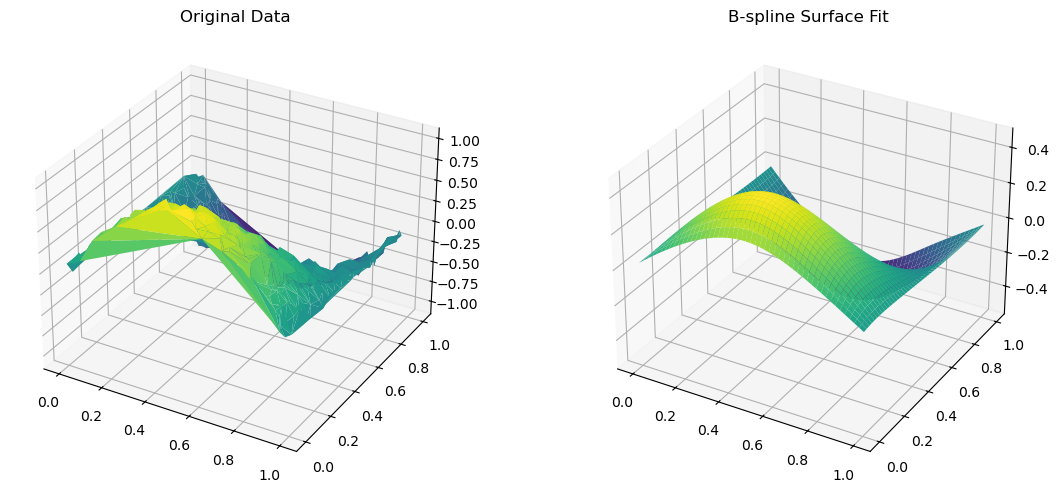

In [15]:
w = fit_sgdreg_2d(B2D_flat, z)
print("MSE:", (((B2D_flat @ w).flatten()-z)**2).mean())
z_pred = (B2D_grid_flat @ w).reshape(50, 50)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2)
ax1.set_title("Original Data")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(grid_x, grid_y, z_pred, cmap='viridis')
ax2.set_title("B-spline Surface Fit")
plt.tight_layout()
plt.show()


# and for good measure, PLSRegressor:

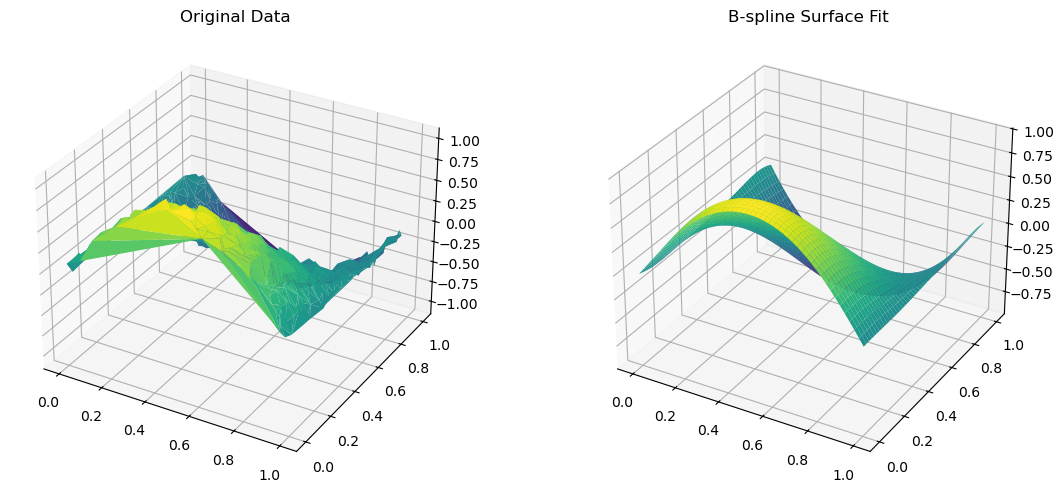

In [16]:
from sklearn.cross_decomposition import PLSRegression

z_pred = PLSRegression(n_components=2).fit(
    B2D_flat, z
).predict(
    B2D_grid_flat
).reshape(
    50, 50
)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot_trisurf(x, y, z, cmap='viridis', linewidth=0.2)
ax1.set_title("Original Data")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(grid_x, grid_y, z_pred, cmap='viridis')
ax2.set_title("B-spline Surface Fit")
plt.tight_layout()
plt.show()

# Bonus: Legendre

Another type of function suitable for smooth fitting is Legendre polynomials. I find it a bit more intuitive since there's just a regular `f(x) = ...` equation for each degree (see the [first few on wikipedia](https://en.wikipedia.org/wiki/Legendre_polynomials)) instead of a recursive definition . The main practical difference here is that the smooth fitting properties of Legendre polynomials only work between -1 and 1, so the input data should be scaled. 


In [17]:
from numpy.polynomial.legendre import legvander, legval

def normalize(arr):
    normalized = (arr - arr.min()) / (arr.max() - arr.min())*2 - 1
    return normalized

degree = 8

X_leg = legvander(normalize(X), degree)

In [18]:
w = LinearRegression(fit_intercept=False).fit(X_leg, Y).coef_

the result is suitably smooth and fits the data nicely: 

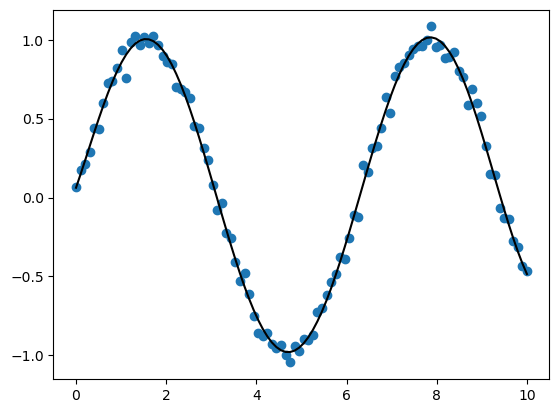

In [19]:
plt.scatter(X, Y)
plt.plot(X, X_leg.dot(w), c='k')

and plotting the individual curves is also delightful: 


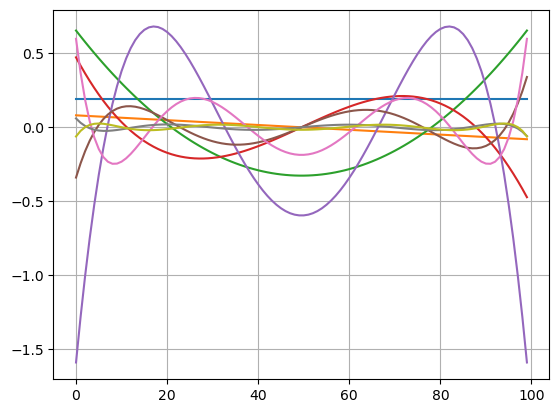

In [20]:
for i in range(w.shape[0]):
    plt.plot(
        (X_leg[:,i:i+1] @ w[i:i+1]).squeeze(),
    )
plt.grid()
